### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from datetime import datetime

### Mount google drive 

Lets access training and testing data. ToDo: External test data 

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### Upload wrap-around artifact training dataset
The wrap-around artifact training dataset contains images with or without the artifact and corresponding labels: 1 or 0

In [ ]:
import os
import numpy as np

#Check if file exists, can make this cell much more elegent: ToDo
print(os.listdir('/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data'))

# This solution below is better but does not work reliably - flaky
# DATA_URL = 'https://drive.google.com/drive/u/0/folders/1zCm3HucWIY4pJb3h60KJsyEhrvYWPyXp'
# path = tf.keras.utils.get_file('train_Gibbs.h5', DATA_URL)
# print(path)

folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/wraparound_vertical'
# folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/wraparound_horizontal'
# folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/wraparound_slices'

# with np.load(file_path, allow_pickle=True) as data:
train_images = np.load(os.path.join(folder_path, 
                                    'train_data.npz'))['arr_0']
train_labels = np.load(os.path.join(folder_path, 
                                    'train_labels.npz'))['arr_0']

#  train_images = data['x_train']
#  train_labels = data['y_train']
#  print(train_images.shape)
#  train_images = np.transpose(train_images,[2,0,1]) #Examples need to axis 2
#  print(train_images.shape)

['wraparound_sagittal', 'activations_Gibbs.mat', 'activations_wrap_axial.mat', 'activations_wrap_val.mat', 'twin_slices.npz', 'activations_wrap_twin.mat', 'train_labels.npz', 'train_data.npz', 'test_data.npz', 'test_labels.npz', 'val_labels.npz', 'val_labels (1).npz', 'val_data.npz', 'wraparound_vertical', 'wraparound_horizontal', 'wraparound_slices']


In [ ]:
folder_path

'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/wraparound_vertical'

In [ ]:
s = train_images.shape
s = train_images.shape
train_images = np.expand_dims(np.moveaxis(train_images, -1, 0),-1) #To enable a single or multi-channel image later
idx = np.random.permutation(len(train_images))
train_images = train_images[idx,...]
train_labels = train_labels[idx]
print(train_images.shape)

(14036, 256, 256, 1)


### Verify the data

To verify that the dataset looks correct, let's plot the first 12 images from the training set and display the class name below each image.


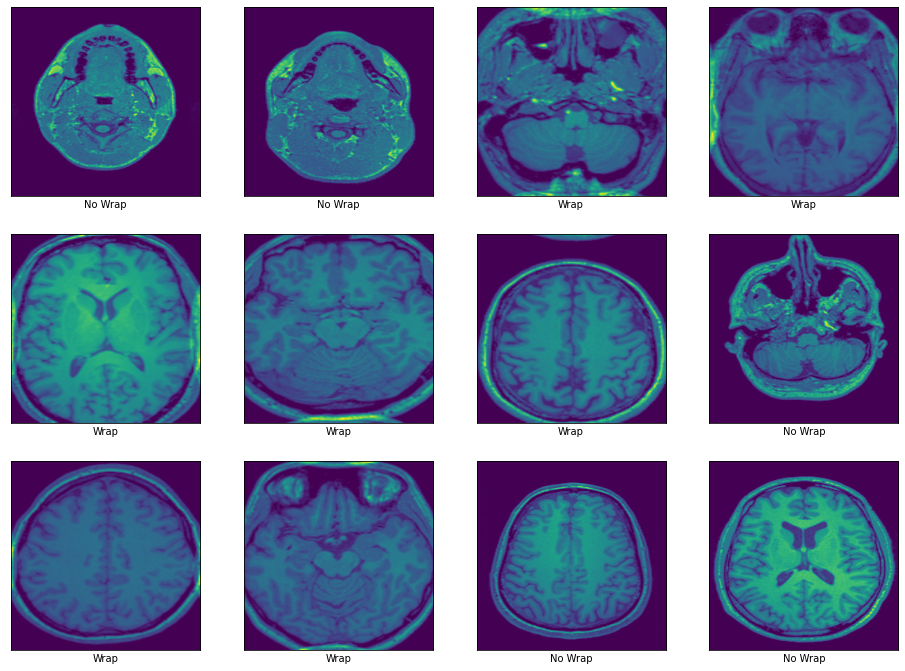

In [ ]:
class_names = ['No Wrap', 'Wrap']
import matplotlib.pyplot as plt

j =1
plt.figure(figsize=(16,16))
for i in range(12*j,12*(j+1)):
    plt.subplot(4,4,i+1-12*j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
  
    temp = 255*np.squeeze(train_images[i,:,:,0])
    temp = temp.astype(np.uint16)
    # plt.imshow(temp,cmap=plt.get_cmap('magma')) # Fix colormap
    plt.imshow(temp)
    plt.gray
    # plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [ ]:
input_shape_h = (256, 195,1)
input_shape_v = (195, 256,1)
input_shape_s = (256, 256, 1)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape_s))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))

Let's display the architecture of our model so far.

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 256). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(288, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2))

Here's the complete architecture of our model.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 288)       663840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 288)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 288)       746784    
_________________________________________________________________
flatten (Flatten)            (None, 48672)             0         
_________________________________________________________________
dense (Dense)                (None, 288)               1

### Compile and train the model

In [ ]:
before = datetime.now()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#  validation_data=(test_images, test_labels))
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
439/439 [==============================] - 173s 375ms/step - loss: 0.1176 - accuracy: 0.9533
Epoch 2/5
439/439 [==============================] - 161s 368ms/step - loss: 0.0055 - accuracy: 0.9985
Epoch 3/5
439/439 [==============================] - 161s 367ms/step - loss: 7.7078e-07 - accuracy: 1.0000
Epoch 4/5
439/439 [==============================] - 161s 367ms/step - loss: 1.0843e-07 - accuracy: 1.0000
Epoch 5/5
439/439 [==============================] - 161s 367ms/step - loss: 9.4682e-08 - accuracy: 1.0000


In [ ]:
after = datetime.now()

In [ ]:
dt = after - before
dt

datetime.timedelta(seconds=824, microseconds=981330)

In [ ]:
model.save('my_model2.h5') 

In [ ]:
np.save('my_history.npy',history.history)

### Evaluate the model

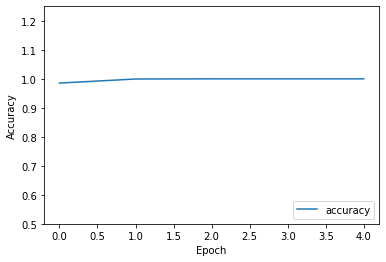

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.25])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# Activation layers

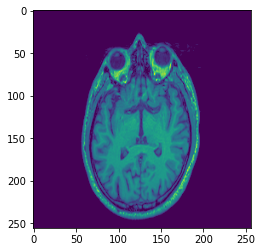

(1, 256, 256, 1)


In [ ]:
# Activation layers 
# plot_model(model, to_file='model_plot_deblur.png', show_shapes=True, show_layer_names=True)
import scipy.io as sio
activations_fname = '/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/activations_wrap_axial.mat' 
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input                             
x = (train_images[4:5,:,:,:])
plt.imshow(np.squeeze(x.astype(np.float64)))
plt.show()
print(x.shape)
activations = activation_model.predict(x)
dictOfactivations = {'Layer' + str(i): activations[i] for i in range(0, len(activations))}
sio.savemat(activations_fname, dictOfactivations)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58]


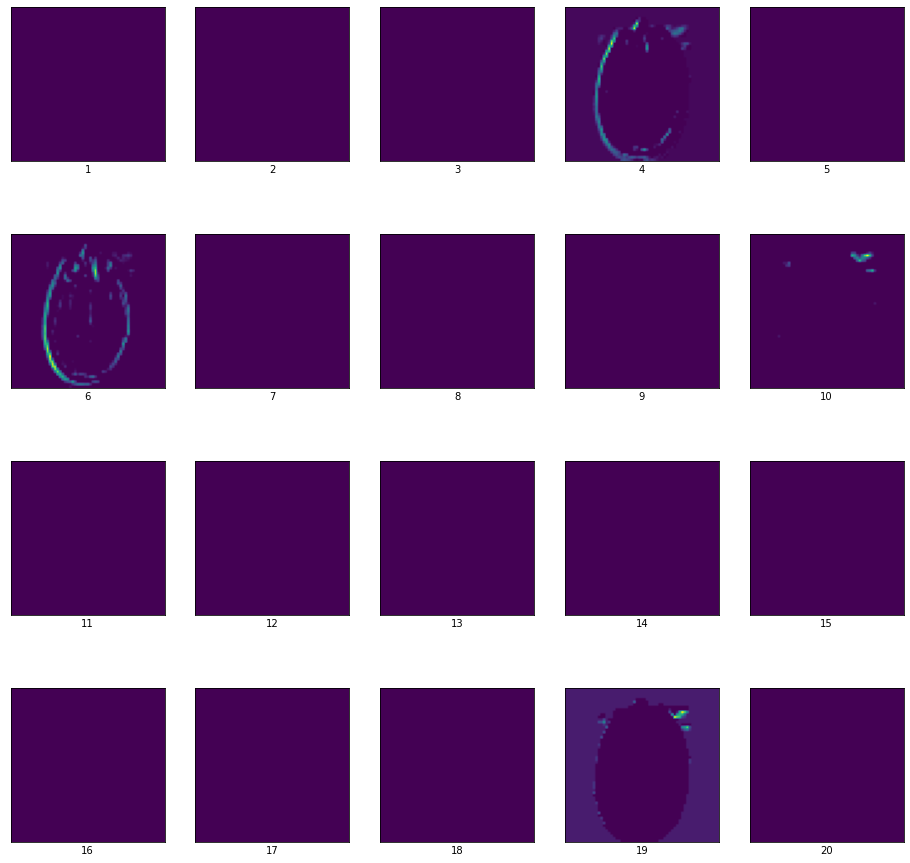

In [ ]:
# filters in a given layer
layer_vis =2
step_ind = int(activations[layer_vis].shape[2]/16)
filter_ind = list(range(1,activations[layer_vis].shape[2],step_ind))
print(filter_ind)
plt.figure(figsize=(16,16))

for i in range(len(filter_ind)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    temp_init = activations[layer_vis]
    temp = 255*np.squeeze(temp_init[0,:,:,filter_ind[i]])
    temp = temp.astype(np.uint16)
    plt.imshow(temp)
    # plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(i+1)
plt.show()

#Validation

Load the validation data: 10 slices Godwin, 90 validation slices  from training.

In [ ]:
folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data'

# with np.load(file_path, allow_pickle=True) as data:
val_images = np.load(os.path.join(folder_path, 
                                    'val_data.npz'))['arr_0']
val_labels = np.load(os.path.join(folder_path, 
                                    'val_labels.npz'))['arr_0']

In [ ]:
folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data'

# with np.load(file_path, allow_pickle=True) as data:
test_images = np.load(os.path.join(folder_path, 
                                    'test_data.npz'))['arr_0']
test_labels = np.load(os.path.join(folder_path, 
                                    'test_labels.npz'))['arr_0']

In [ ]:
val_images = np.expand_dims(np.moveaxis(val_images, -1, 0),-1) #To enable a single or multi-channel image later
print(val_images.shape)

(1, 2909, 256, 256, 1)


In [ ]:
model.evaluate(val_images, val_labels)

91/91 [==============================] - 12s 135ms/step - loss: 0.5539 - accuracy: 0.8738


[0.5538927316665649, 0.873839795589447]

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
y_pred=model.predict(test_images)

In [ ]:
pred_labels = []
for pred in y_pred:
    pred_labels.append(np.argmax(pred))

In [ ]:
precision = precision_score(y_true=test_labels, y_pred=pred_labels)
precision

0.8970886932972241

In [ ]:
recall = recall_score(y_true=test_labels, y_pred=pred_labels)
recall

0.8677144728225278

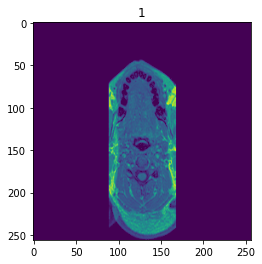

In [ ]:
i=69
plt.imshow(np.squeeze(255*val_images[i,...,0]))
plt.title(str(val_labels[i]))
plt.show()

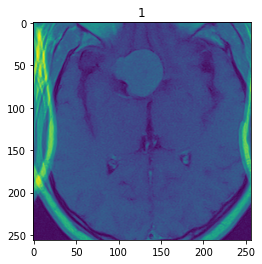

(1, 256, 256, 1)


In [ ]:
# Activation layers 
# plot_model(model, to_file='model_plot_deblur.png', show_shapes=True, show_layer_names=True)
import scipy.io as sio
activations_fname = '/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/activations_wrap_val.mat' 
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input                             

idx = 2

x = (val_images[idx:idx+1,:,:,:])
plt.imshow(np.squeeze(x.astype(np.float64)))
plt.title(val_labels[idx])
plt.show()
print(x.shape)
activations = activation_model.predict(x)
dictOfactivations = {'Layer' + str(i): activations[i] for i in range(0, len(activations))}
sio.savemat(activations_fname, dictOfactivations)

In [ ]:
pred = model.predict(val_images[idx:idx+1,...])
pred

array([[ 0.23374122, -0.21162285]], dtype=float32)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58]


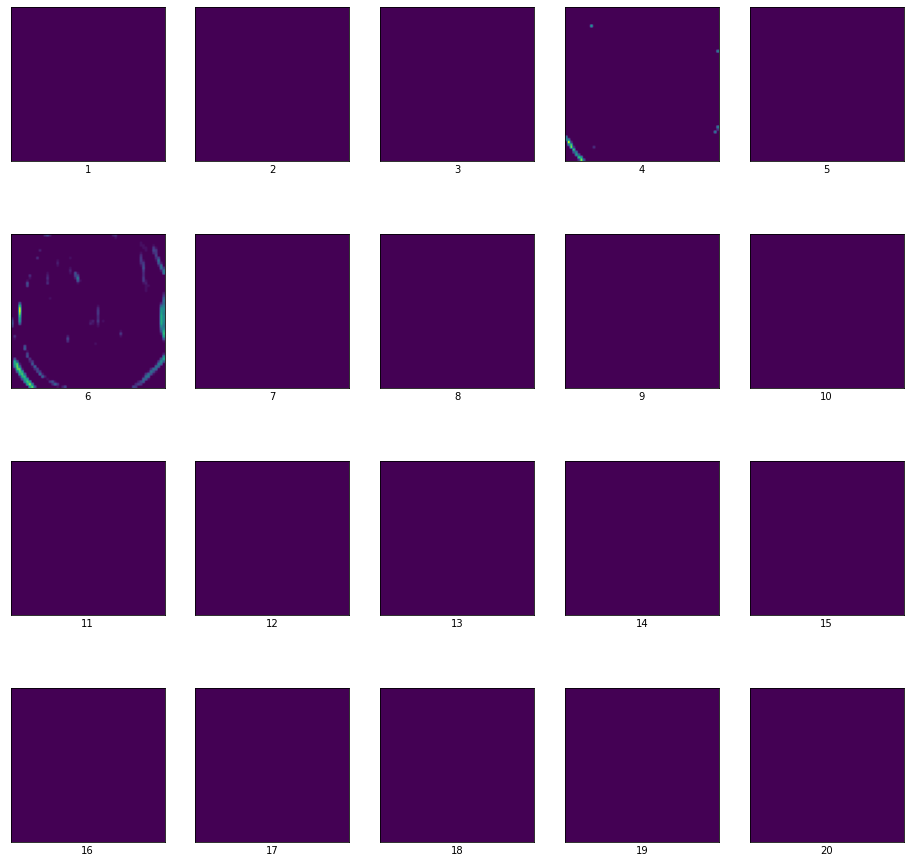

In [ ]:
# filters in a given layer
layer_vis =2
step_ind = int(activations[layer_vis].shape[2]/16)
filter_ind = list(range(1,activations[layer_vis].shape[2],step_ind))
print(filter_ind)
plt.figure(figsize=(16,16))

for i in range(len(filter_ind)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    temp_init = activations[layer_vis]
    temp = 255*np.squeeze(temp_init[0,:,:,filter_ind[i]])
    temp = temp.astype(np.uint16)
    plt.imshow(temp)
    # plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(i+1)
plt.show()

#Twin slices

In [ ]:
val_labels

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

In [ ]:
np.array(twin_labels)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
folder_path = r'/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data'

# with np.load(file_path, allow_pickle=True) as data:
twin_images = np.load(os.path.join(folder_path, 
                                    'twin_slices.npz'))['arr_0']
twin_labels = np.array([0, 1] * int(twin_images.shape[0]/2))

In [ ]:
twin_images = np.expand_dims(twin_images,-1) #To enable a single or multi-channel image later
print(twin_images.shape)

(22, 256, 256, 1)


In [ ]:
model.evaluate(twin_images, twin_labels)

1/1 [==============================] - 0s 2ms/step - loss: 0.0243 - accuracy: 1.0000


[0.024311242625117302, 1.0]

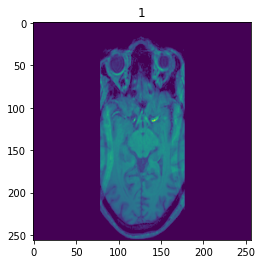

(1, 256, 256, 1)


In [ ]:
# Activation layers 
# plot_model(model, to_file='model_plot_deblur.png', show_shapes=True, show_layer_names=True)
import scipy.io as sio
activations_fname = '/content/gdrive/My Drive/Colab Notebooks/ArtifactID_data/activations_wrap_twin.mat' 
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input,
                                outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input                             

idx = 9

x = (twin_images[idx:idx+1,:,:,:])
plt.imshow(np.squeeze(x.astype(np.float64)))
plt.title(twin_labels[idx])
plt.show()
print(x.shape)
activations = activation_model.predict(x)
dictOfactivations = {'Layer' + str(i): activations[i] for i in range(0, len(activations))}
sio.savemat(activations_fname, dictOfactivations)

In [ ]:
pred = model.predict(val_images[idx:idx+1,...])
pred

array([[-0.55444735,  0.79913086]], dtype=float32)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58]


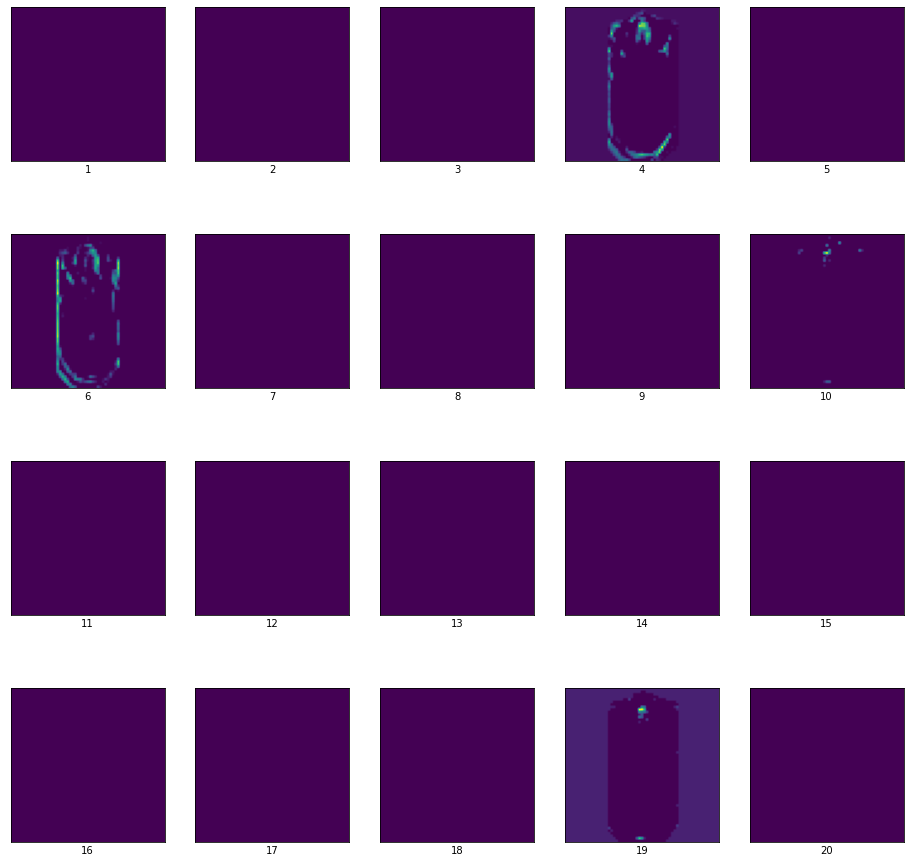

In [ ]:
# filters in a given layer
layer_vis =2
step_ind = int(activations[layer_vis].shape[2]/16)
filter_ind = list(range(1,activations[layer_vis].shape[2],step_ind))
print(filter_ind)
plt.figure(figsize=(16,16))

for i in range(len(filter_ind)):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    temp_init = activations[layer_vis]
    temp = 255*np.squeeze(temp_init[0,:,:,filter_ind[i]])
    temp = temp.astype(np.uint16)
    plt.imshow(temp)
    # plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(i+1)
plt.show()